In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import os

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from scipy import stats

load_dotenv()
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100

warnings.filterwarnings("ignore")


# Feature engineering :

Les resultats des regressions linéaires (OLS, LASSO, Ridge, ENET) se sont montrés assez decevants : le score R2 depasse rarement 0.6. <br>
Certaines features peuvent eventuellement être retouchées pour augmenter la precision de la modelisation. <br>

- Les données lineaires continues ont déjà été standardisées et scalées. Analyse de la distribution pour potentiel passage au Log/sqrt/box_cox.
- Conversion de "Year Built" vers "Building Age", cela devrait reduire le poids de cette variable qui ne semblait pas avoir beaucoup d'influence sur les emissions de GES ou la consommation electrique durant l'analyse.
- Ajout d'une nouvelle metrique booleene : Is_Energy_Star_Certified (E* >= 75). Verifications des possibilités de predire non pas la note mais la certification ou non d'un batiment. Si les resultats de cette modelisation (nb_xy_estar.ipynb) sont satisfaisant, cela peut etre une alternative a l'elimination totale de cette variable au profit d'un calcul plus simple.
- Application de ces parametres sur le dataset commun et sur les donnees deja reparties (test/train) sur les GES

In [2]:
file_train, file_test = "./data/train_set_70percent_ghg.csv", "./data/test_set_30percent_ghg.csv"
common_file = "./data/seattle_predict_ghg_eui.csv"


In [3]:
df_ghg_eui = pd.read_csv(common_file)
df_ghg_eui.set_index("OSEBuildingID", inplace=True)


In [4]:
df_ghg_eui.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_nbhood_BALLARD',
       'ohe_nbhood_CENTRAL', 'ohe_nbhood_DELRIDGE', 'ohe_nbhood_DOWNTOWN',
       'ohe_nbhood_EAST', 'ohe_nbhood_GREATER DUWAMISH',
       'ohe_nbhood_LAKE UNION', 'ohe_nbhood_MAGNOLIA / QUEEN ANNE',
       'ohe_nbhood_NORTH', 'ohe_nbhood_NORTHEAST', 'ohe_nbhood_NORTHWEST',
       'ohe_nbhood_SOUTHEAST', 'ohe_nbhood_SOUTHWEST', 'ohe_ptype_Hospital',
       'ohe_ptype_Hotel', 'ohe_ptype_K-12 School', 'ohe_ptype_Large Office',
       'ohe_ptype_Mixed Use Property', 'ohe_ptype_Office', 'ohe_ptype_Other',
       'ohe_ptype_Refrigerated Warehouse', 'ohe_ptype_Residence Hall',
    

- Le prefixe OHE, One Hot Encoded, n'est pas a modifier.
- Les features categorielles continues : NumberofBuildings, NumberofFloors sont ingorées.
- Les features target sont exclues des matrices de modelisation, il est inutile de les modifier
- L'etude se porte sur : <br>
 `'scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)' 'scaled_PropertyArea(SquareMetre)Total' 'scaled_SourceEUI(kWh/m2)', 'scaled_NaturalGas(kWh)', 'YearBuilt', 'ENERGYSTARScore',`

## 1 : Changement de la variable "YearBuilt" vers "BuildingAge"

In [5]:
df_ghg_eui["BuildingAge"] = np.nan
for index, row in df_ghg_eui.iterrows():
    df_ghg_eui.loc[index, "BuildingAge"] = int(2022 - row["YearBuilt"])

df_ghg_eui.drop(columns=["YearBuilt"], inplace=True)


## 2 : Ajout d'une nouvelle variable : Energy Star Certified

In [6]:
df_ghg_eui["EnergyStarCert"] = 0
for index, row in df_ghg_eui.iterrows():
    if row["ENERGYSTARScore"] >= 75:
        df_ghg_eui.loc[index, "EnergyStarCert"] = 1


## 3 : Verification des variables lineaires continues pour eventuel passage au log

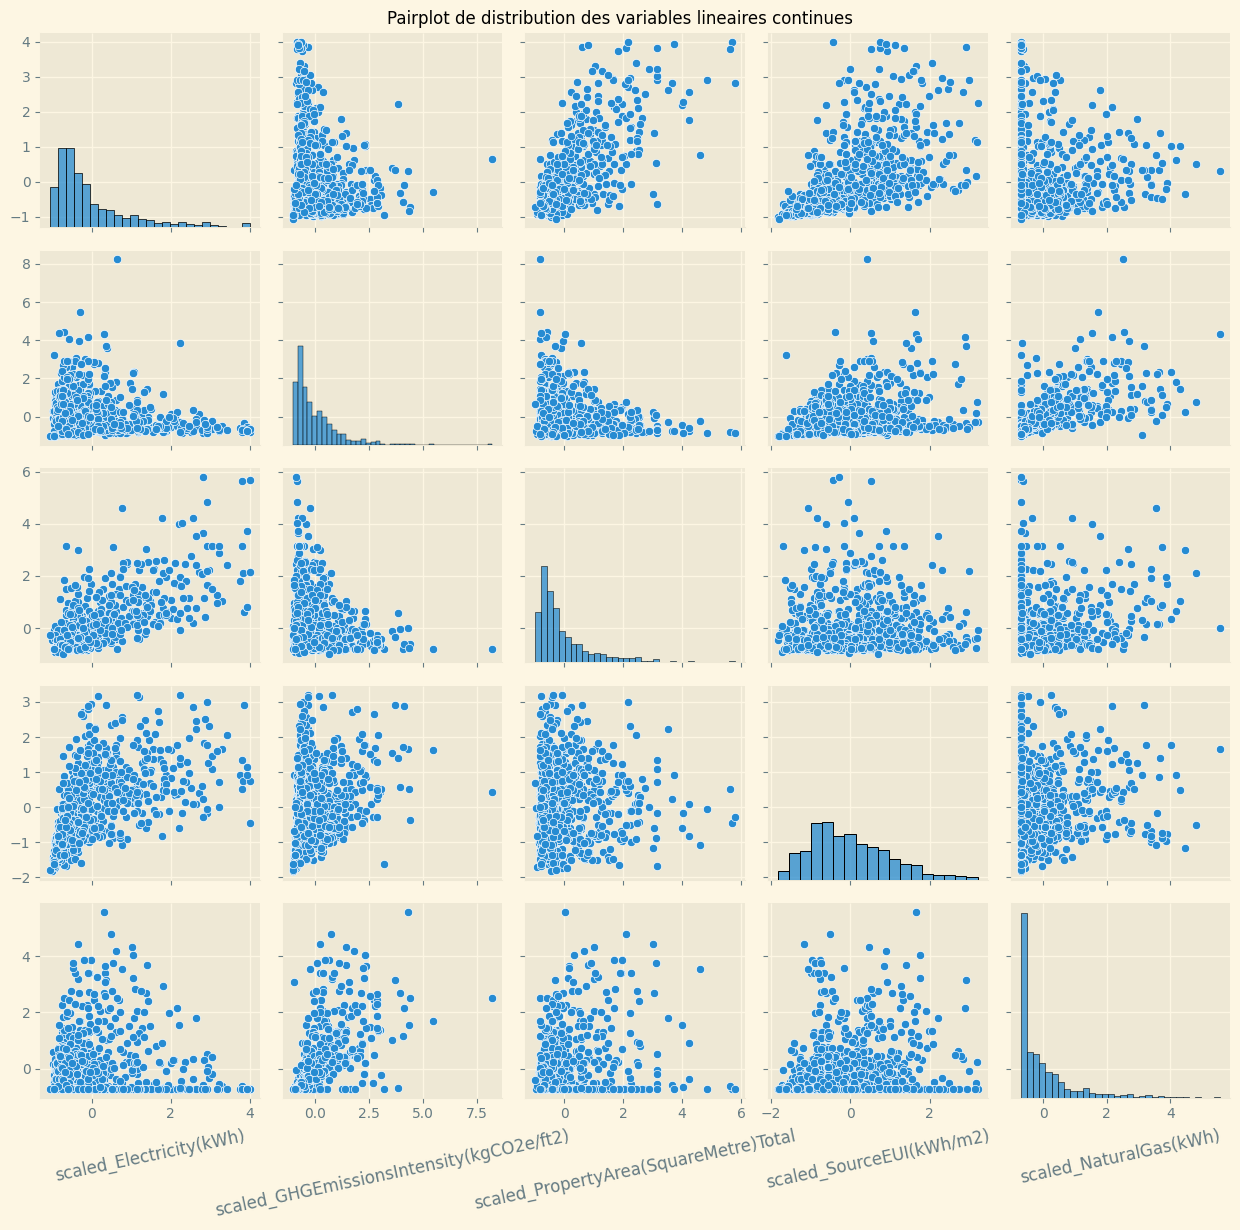

In [7]:
col_subset = [
    "scaled_Electricity(kWh)", "scaled_GHGEmissionsIntensity(kgCO2e/ft2)", 
    "scaled_PropertyArea(SquareMetre)Total", "scaled_SourceEUI(kWh/m2)", 
    "scaled_NaturalGas(kWh)"
    ]

pairplot = sns.pairplot(
    data=df_ghg_eui[col_subset]
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues")
#
###

plt.tight_layout()
plt.show()


#### Observations :

- On peut voir que des variables comme scaled_NaturalGas et scaled_ghgemissionIntensity ne sont pas normalement distribuées. SourceEUI semble etre plus normalement distribué.
- On peut passer toutes les donnees au log pour voir si les changements sont significatifs (sauf source EUI)

#### Actions : tentatives de passage au log/sqrt/box_cox, visualisation et enregistrement du .skew()


In [8]:
skew_std_scaled = dict.fromkeys(col_subset)
for col in skew_std_scaled.keys():
    skew_std_scaled[col] = df_ghg_eui[col].skew()


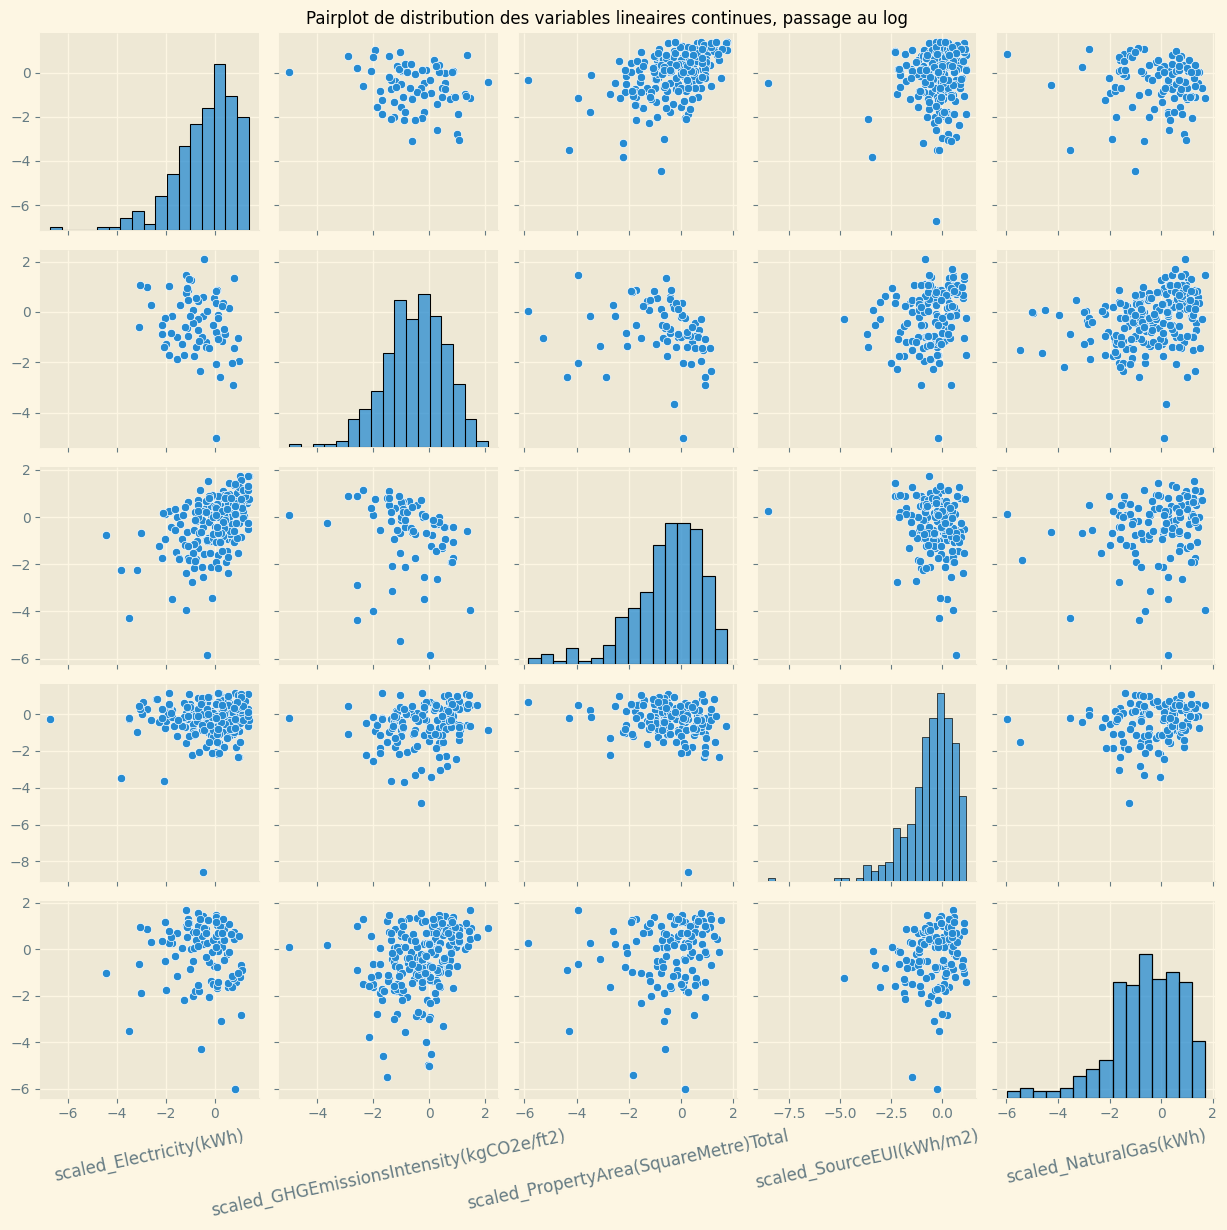

In [9]:
log_data = df_ghg_eui[col_subset]

for column in log_data.columns:
    log_data[column] = np.log(log_data[column])

pairplot = sns.pairplot(
    data=log_data
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, passage au log")
#
###

plt.tight_layout()
plt.show()


In [10]:
skew_logged = dict.fromkeys(col_subset)
for col in skew_logged.keys():
    skew_logged[col] = log_data[col].skew()


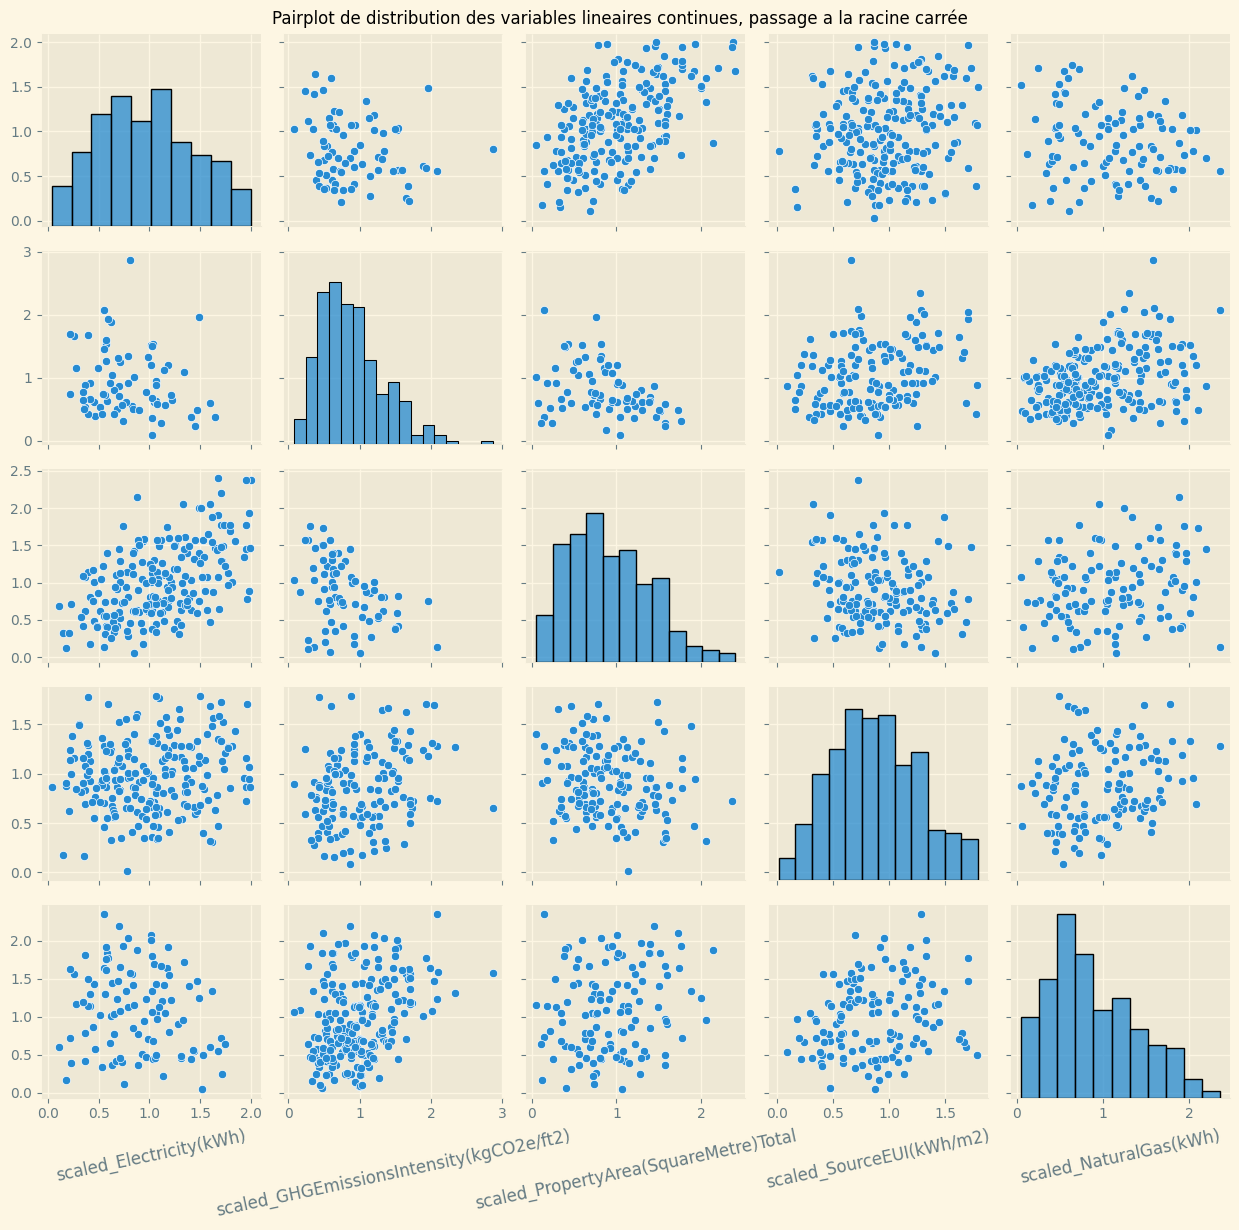

In [11]:
sqrt_data = df_ghg_eui[col_subset]

for column in sqrt_data.columns:
    sqrt_data[column] = np.sqrt(sqrt_data[column])

pairplot = sns.pairplot(
    data=sqrt_data
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, passage a la racine carrée")
#
###

plt.tight_layout()
plt.show()


In [12]:
skew_sqrt = dict.fromkeys(col_subset)
for col in skew_sqrt.keys():
    skew_sqrt[col] = sqrt_data[col].skew()


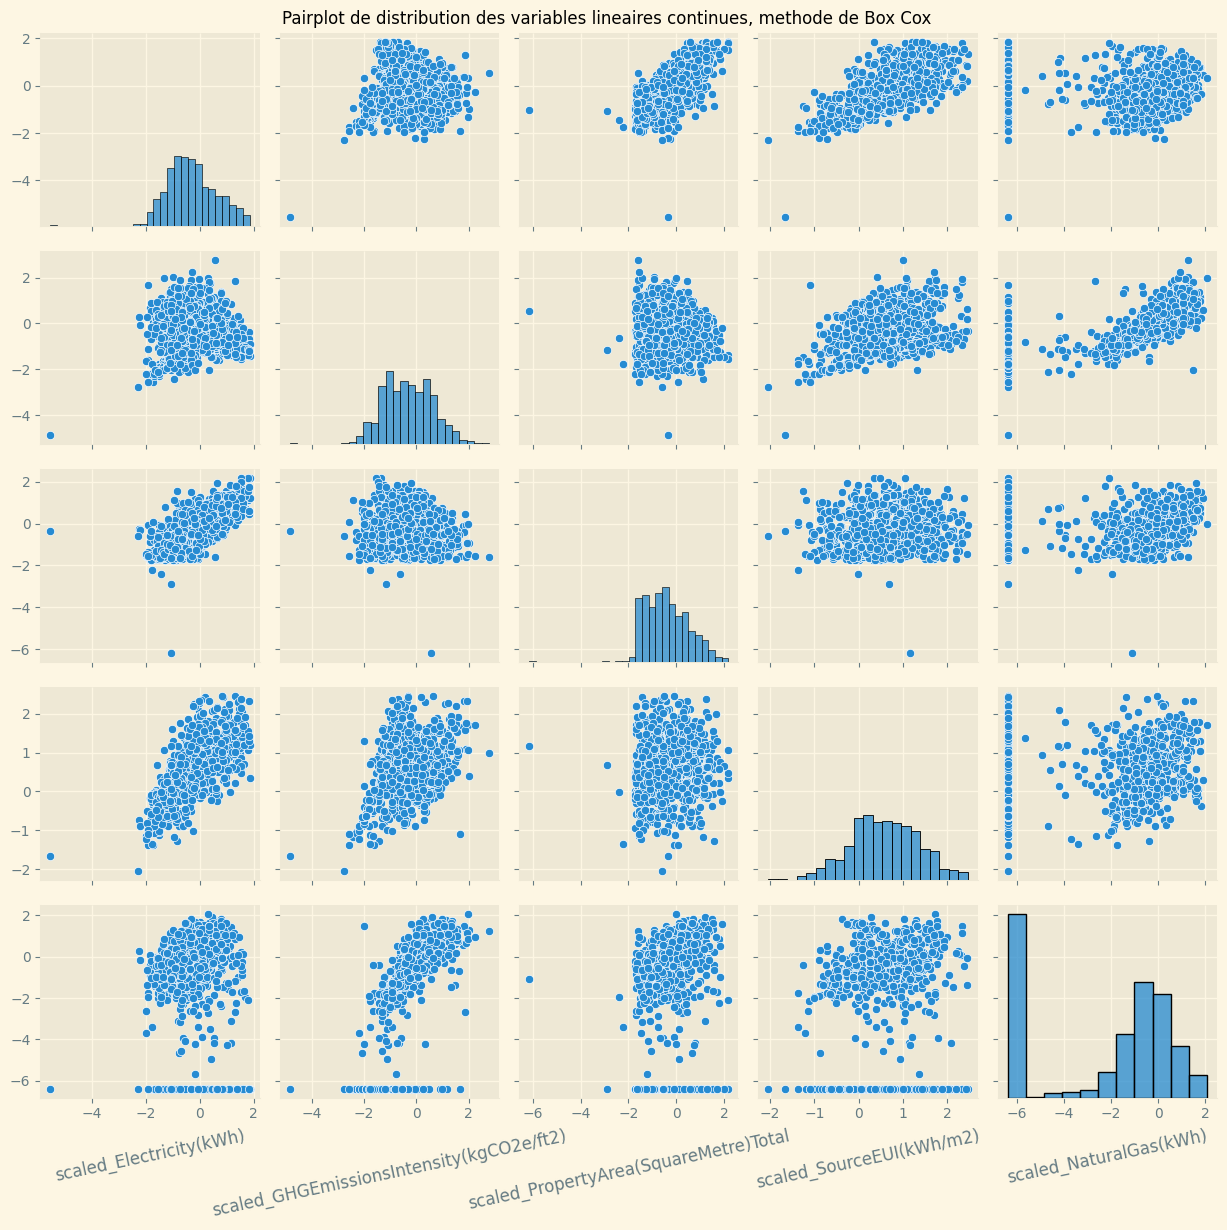

In [13]:
box_cox_data = df_ghg_eui[col_subset]

for column in box_cox_data.columns:
    values = box_cox_data[column].values
    constant = abs(min(values)) + 0.000001
    new_values = values + constant
    new_values = stats.boxcox(new_values)
    box_cox_data[column] = new_values[0]

pairplot = sns.pairplot(
    data=box_cox_data
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, methode de Box Cox")
#
###

plt.tight_layout()
plt.show()


In [14]:
skew_box_cox = dict.fromkeys(col_subset)
for col in skew_box_cox.keys():
    skew_box_cox[col] = box_cox_data[col].skew()


In [15]:
names = [name[7:] for name in skew_std_scaled.keys()]  # Removed "scaled_"
results = pd.DataFrame(data=skew_std_scaled.values(), columns=["standard_scaled"], index=skew_std_scaled.keys())
results["log"] = skew_logged.values()
results["sqrt"] = skew_sqrt.values()
results["box_cox"] = skew_box_cox.values()
results = results.T  # Transformation as index


In [16]:
results


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh)
standard_scaled,1.784896,2.279158,2.231357,0.713349,2.154545
log,-1.232922,-0.530993,-1.222125,-1.721356,-0.980981
sqrt,0.281975,0.921433,0.551494,0.192850,0.590438
box_cox,0.103214,0.039406,0.125473,-0.038873,-0.506924


Utilisation de la valeur absolue minimale pour trouver la transformation adaptée à chaque variable :

In [17]:
for col in results.columns:
    temp = abs(results[col])
    print(f"Minimal skew with {temp.idxmin()} for col {col[7:]} : skew = {results[col][temp.idxmin()]}")

print("\n##############\n")
for col in results.columns:
    temp = abs(results[col].drop(index=["box_cox"]))
    print(f" Second minimal skew with {temp.idxmin()} for col {col[7:]} : skew = {results[col][temp.idxmin()]}")



Minimal skew with box_cox for col Electricity(kWh) : skew = 0.10321425249720378
Minimal skew with box_cox for col GHGEmissionsIntensity(kgCO2e/ft2) : skew = 0.039405800101279205
Minimal skew with box_cox for col PropertyArea(SquareMetre)Total : skew = 0.1254733935528116
Minimal skew with box_cox for col SourceEUI(kWh/m2) : skew = -0.03887251028394238
Minimal skew with box_cox for col NaturalGas(kWh) : skew = -0.5069237380259308

##############

 Second minimal skew with sqrt for col Electricity(kWh) : skew = 0.28197470118386964
 Second minimal skew with log for col GHGEmissionsIntensity(kgCO2e/ft2) : skew = -0.5309926555138107
 Second minimal skew with sqrt for col PropertyArea(SquareMetre)Total : skew = 0.5514944422102311
 Second minimal skew with sqrt for col SourceEUI(kWh/m2) : skew = 0.19285007167271395
 Second minimal skew with sqrt for col NaturalGas(kWh) : skew = 0.5904377209211339


## Conclusions : 

- L'utilisation de la methode de Box Cox semble etre la meilleure pour reduire l'asymetrie de distribution
- Si l'on souhaite utiliser une autre approche que la methode Box Cox, le passage au log est le plus adapté pour les emissions de GES, les autres colonnes beneficient d'avantage de la reduction a la racine carrée
- Les deux nouvelles variables créées sont à remplacer dans les études
- Pour eviter la redondance, on n'utilisera qu'un seul indicateur E* a la fois pour determiner si E* certified est benefique et s'il est plus simple a determiner que la note en elle meme.